# **Using BERT for sentiment analysis in stock reviews with webscraping**

In [2]:
!pip install transformers
import os
import gdown
import torch
import numpy as np
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

% matplotlib inline

from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.request import Request

# gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
# gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

n = 20 #the # of article headlines displayed per ticker
tickers = ['AAPL', 'TSLA', 'AMZN']

def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print ("Train and Test Files Loaded as train.csv and test.csv")

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
NONE = 4 * [None]
RND_SEED=2020




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.6 MB/s 
     |████████████████████████████████| 6.6 MB 29.7 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 42.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
--2022-06-12 21:59:41--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29264 (29K) [application/vnd.ms-excel]
Saving to: ‘finance_test.csv’

fina

In [3]:
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    resp = urlopen(req)    
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')
    
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            if i == n-1:
                break
except KeyError:
    pass

parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
print(news)

    Ticker       Date     Time  \
0     AAPL  Jun-12-22  04:08PM   
1     AAPL  Jun-12-22  04:05PM   
2     AAPL  Jun-12-22  03:56PM   
3     AAPL  Jun-12-22  07:00AM   
4     AAPL  Jun-12-22  05:43AM   
..     ...        ...      ...   
295   AMZN  Jun-08-22  01:00PM   
296   AMZN  Jun-08-22  12:39PM   
297   AMZN  Jun-08-22  12:21PM   
298   AMZN  Jun-08-22  12:10PM   
299   AMZN  Jun-08-22  11:55AM   

                                              Headline  
0    Exxon May Be Making More Than God. But Apple a...  
1    Apple Needs One More Thingand It Will Have to ...  
2    Apple Is Delving Into Buy Now Pay Later. These...  
3    Looking for Passive Income? Buy These 3 Top Te...  
4    2 Warren Buffett Stocks to Buy Now and Hold Fo...  
..                                                 ...  
295  Former Amazon executive Dave Clark joins logis...  
296         Why Netflix buying Roku doesn't make sense  
297  Exiting Amazon retail CEO Dave Clark tapped to...  
298  Fast fashion sal

In [4]:
df_train = get_finance_train()
df_test = get_finance_test()

In [5]:
sentences = df_train["Sentence"].values
labels = df_train["Label"].values

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
sentences_with_special_tokens = []
for sentence in sentences:
  sentence = "[CLS] " + sentence + " [SEP]"
  sentences_with_special_tokens.append(sentence)
print(sentences_with_special_tokens[0])

[CLS] Autotank Group is part of Aspo 's Systems Division . [SEP]


In [8]:
tokenized_texts = []
for sentence in sentences_with_special_tokens:
  sentence = tokenizer.tokenize(sentence)
  tokenized_texts.append(sentence)
print(tokenized_texts[0])

['[CLS]', 'auto', '##tan', '##k', 'group', 'is', 'part', 'of', 'as', '##po', "'", 's', 'systems', 'division', '.', '[SEP]']


In [9]:
input_ids = []
for sentence in tokenized_texts:
  sentence = tokenizer.convert_tokens_to_ids(sentence)
  input_ids.append(sentence)
print(input_ids[0])

[101, 8285, 5794, 2243, 2177, 2003, 2112, 1997, 2004, 6873, 1005, 1055, 3001, 2407, 1012, 102]


In [10]:
input_ids = pad_sequences(input_ids, 
                          maxlen=128,
                          dtype="long",
                          truncating="post", 
                          padding="post")
print(input_ids[0])

[ 101 8285 5794 2243 2177 2003 2112 1997 2004 6873 1005 1055 3001 2407
 1012  102    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [11]:
attention_masks = []

for sentence in input_ids:
  sentence = [float(i>0) for i in sentence]
  attention_masks.append(sentence)
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [12]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels, test_size = 0.15, random_state=RND_SEED)

In [13]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, test_size = 0.15, random_state=RND_SEED)

In [14]:
train_inputs = torch.tensor(np.array(X_train));
validation_inputs = torch.tensor(np.array(X_val));
train_masks = torch.tensor(np.array(train_masks));
validation_masks = torch.tensor(np.array(validation_masks));
train_labels = torch.tensor(np.array(y_train));
validation_labels = torch.tensor(np.array(y_val));

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels);
train_sampler = RandomSampler(train_data); 
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size);
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels);
validation_sampler = SequentialSampler(validation_data); 
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size);

In [15]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3,    
    output_attentions = False, 
    output_hidden_states = False, 
);


model.cuda();

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

'Tesla K80'

In [16]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
epochs = 4

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [17]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

training_loss = []
validation_loss = []
training_stats = []
for epoch_i in range(0, epochs):
    print('Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training the model')
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 20 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)  
        model.zero_grad()    

        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    print("  Average training loss: {0:.2f}".format(avg_train_loss))


    print("Evaluating on Validation Set")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    
    
    print("Validation Loss: {0:.2f}".format(avg_val_loss))
    

    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)
    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy
            
        }
    )
    
print("Training complete!")

Epoch 1 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.69
Evaluating on Validation Set
Validation Accuracy: 0.90
Validation Loss: 0.35
Epoch 2 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.21
Evaluating on Validation Set
Validation Accuracy: 0.96
Validation Loss: 0.15
Epoch 3 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.07
Evaluating on Validation Set
Validation Accuracy: 0.96
Validation Loss: 0.14
Epoch 4 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.04
Evaluating on Validation Set
Validation Accuracy: 0.97
Validation Loss: 0.12
Training complete!


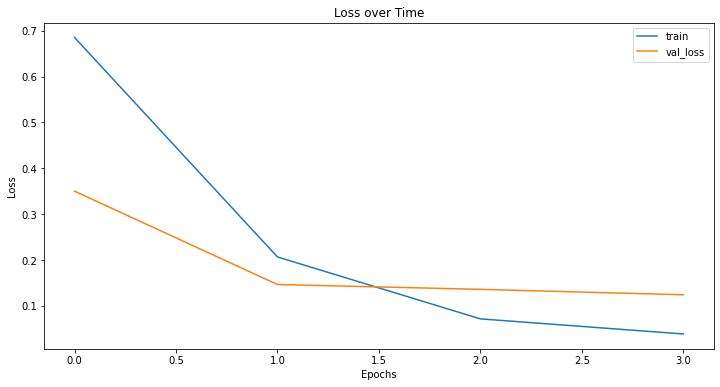

In [18]:
fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(training_loss, label = "train")
plt.plot(validation_loss, label = "val_loss")

plt.legend()
plt.show()

In [19]:
test_sentences = df_test["Sentence"].values
test_labels = df_test["Label"].values



In [20]:
test_input_ids, test_attention_masks = [], []

test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]

tokenized_test_sentences = [tokenizer.tokenize(sent) for sent in test_sentences]

test_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_sentences]

test_input_ids = pad_sequences(test_input_ids, 
                               maxlen=128, 
                               dtype="long",
                               truncating="post", 
                               padding="post")

for sequence in test_input_ids:
  mask = [float(i>0) for i in sequence]
  test_attention_masks.append(mask)

In [21]:
batch_size = 32  
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [41]:

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

  
print ('Test Accuracy: {:.2%}'.format(flat_accuracy(logits, label_ids)))



Predicting labels for 227 test sentences...
Test Accuracy: 100.00%


In [42]:
real_input_ids, real_attention_masks = [], []

real_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in news["Headline"]]

tokenized_real_sentences = [tokenizer.tokenize(sent) for sent in real_sentences]

real_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_real_sentences]

real_input_ids = pad_sequences(real_input_ids, 
                               maxlen=128, 
                               dtype="long",
                               truncating="post", 
                               padding="post")

for sequence in test_input_ids:
  mask = [float(i>0) for i in sequence]
  real_attention_masks.append(mask)


In [44]:
batch_size = 32 
real_input_ids = torch.tensor(real_input_ids)
real_attention_masks = torch.tensor(real_attention_masks)
prediction_data = TensorDataset(real_input_ids, real_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

AssertionError: ignored

In [43]:
predictions = []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
print(outputs)
df_scores = pd.DataFrame(outputs)
news = news.join(df_scores, rsuffix='_right')

SequenceClassifierOutput(loss=None, logits=tensor([[-1.8559,  3.9983, -2.1132],
        [-1.9124,  3.7829, -2.2119],
        [-1.5661, -2.1228,  3.7185]], device='cuda:0'), hidden_states=None, attentions=None)


ValueError: ignored

In [23]:
news['Date'] = pd.to_datetime(news.Date).dt.date

unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

values = []
for ticker in tickers: 
    dataframe = news_dict[ticker]
    dataframe = dataframe.set_index('Ticker')
    dataframe = dataframe.drop(columns = ['Headline'])
    print ('\n')
    print (dataframe.head())
    
    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)
    
df = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'Mean Sentiment']) 
df = df.set_index('Ticker')
df = df.sort_values('Mean Sentiment', ascending=False)
print ('\n')
print (df)

AttributeError: ignored